# Random Forest

O random forest é um modelo de aprendizado de máquina levemente parecido com o decision tree, a diferença é que este modelo cria várias árvores de decisão, coletando seus resultados e combinando-os, para assim, poder obter uma previsão mais precisa e estável, como no exemplo abaixo.

<center>

![image.png](../figures/random_forest_ex.png)

</center>

## Importando as bibliotecas scikit-learn e o Pandas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

## Lendo o Dataset tratado, transformando-o em um DataFrame

In [2]:
df = pd.read_csv('dataset_tratado.csv')

df['ZSN'].value_counts()

ZSN
0    1306
1     394
Name: count, dtype: int64

## Balanceando com o algoritmo Down-sampling

In [3]:
# Separando as classes
df_majority = df[df.ZSN==0]
df_minority = df[df.ZSN==1]
 
# Aplicando o algoritmo Down-sampling na classe minoritária
df_majority_downsampled = resample(df_majority, replace=False, n_samples=394, random_state=123)

# Combinado o DataFrame
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
df_downsampled.ZSN.value_counts()

ZSN
0    394
1    394
Name: count, dtype: int64

## Armazenando nas variáveis nossas colunas referentes a características e rótulos do nosso DataFrame

In [4]:
X = df_downsampled.drop('ZSN', axis=1)  # Armazenando todas as colunas de características, exceto a última pois ela é a coluna de rótulo
y = df_downsampled['ZSN']               # Armazenado a última coluna, que será o nosso rótulo

## Dividindo os dados em conjunto de treino e teste, certificando-se que estão sendo treinadas corretamente e aplicando e imprimindo os gráficos e as métricas necessárias

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [9]:
import shap

In [15]:
shap.initjs()

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
shapValues = explainer.shap_values(X_test)

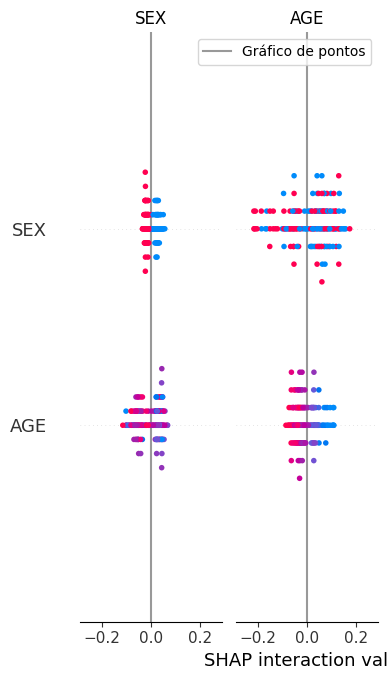

In [19]:
shap.summary_plot(shapValues, X_test, plot_type='dot', show = False)
plt.legend(['Gráfico de pontos'])
plt.show()

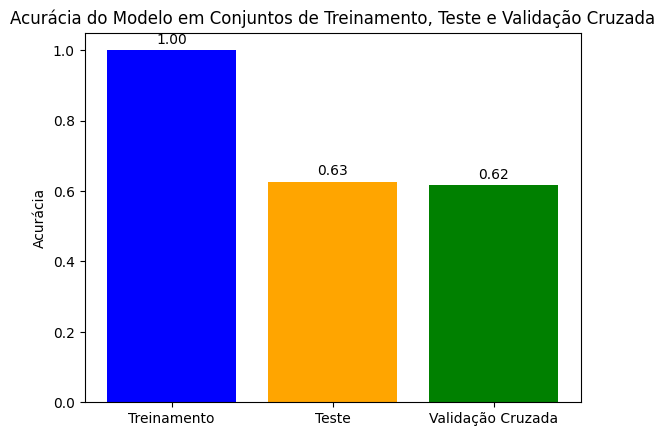

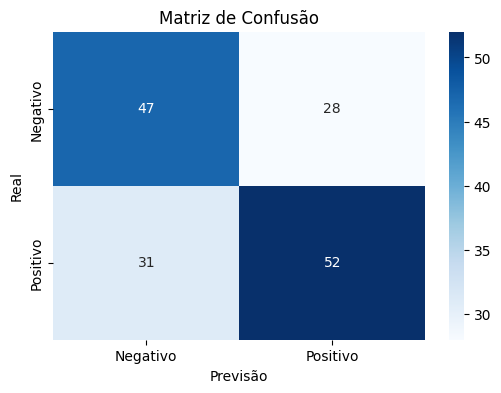

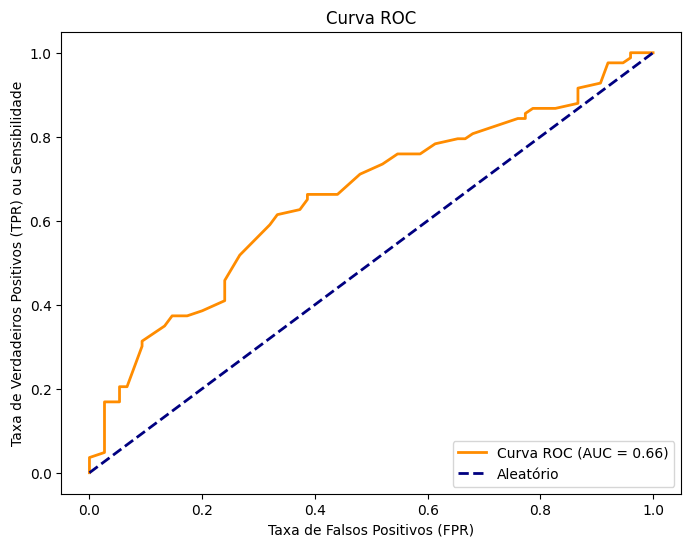

              precision    recall  f1-score   support

           0       0.60      0.63      0.61        75
           1       0.65      0.63      0.64        83

    accuracy                           0.63       158
   macro avg       0.63      0.63      0.63       158
weighted avg       0.63      0.63      0.63       158



In [7]:
try:
    # Fazer previsões no conjunto de teste
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Calcular a acurácia do modelo em treinamento e teste
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    # Adicionar validação cruzada (5 folds)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # Adicionar métrica de acurácia da validação cruzada ao gráfico de barras
    accuracies = [accuracy_train, accuracy_test, np.mean(cv_scores)]

    # Adicionando rótulos e valores nas barras e plotando gráfico
    labels = ['Treinamento', 'Teste', 'Validação Cruzada']
    for i in range(len(labels)):
        plt.text(i, accuracies[i] + 0.01, f'{accuracies[i]:.2f}', ha='center', va='bottom')

    plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
    plt.ylabel('Acurácia')
    plt.title('Acurácia do Modelo em Conjuntos de Treinamento, Teste e Validação Cruzada')
    plt.show()

    # Calcular e plotar a matriz de confusão
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

    # Criando e plotando a curva ROC
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR) ou Sensibilidade')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

    # Calcular e imprimir as métricas
    print(classification_report(y_test, y_test_pred, digits=2, zero_division=1))
    
except Exception as e:
    print(f"Erro: {str(e)}")


In [7]:
probs_test = pd.DataFrame(model.predict_proba(X_test)[:, 1])

In [8]:
probs_test.shape

(158, 1)

In [9]:
y_test.shape

(158,)

In [10]:
probs_test.index

RangeIndex(start=0, stop=158, step=1)

In [11]:
y_test.reset_index(drop=True)

0      1
1      0
2      0
3      0
4      0
      ..
153    0
154    0
155    0
156    1
157    0
Name: ZSN, Length: 158, dtype: int64

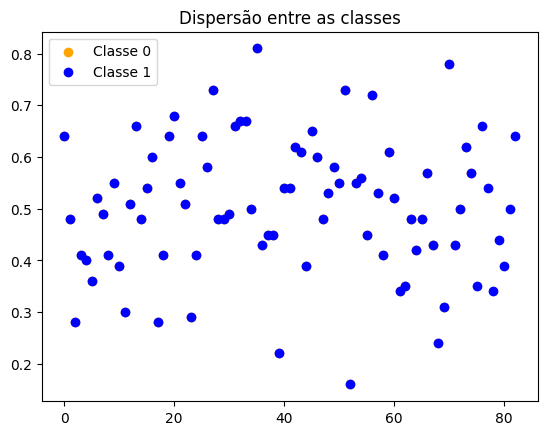

In [15]:
for label in [0, 1]:
    color = 'orange' if label == 0 else "blue"
    class_label = 'Classe 0' if label == 0 else 'Classe 1'
    df_label = y_test[y_test.isin([label])]
    df_probs = probs_test.iloc[df_label.reset_index(drop=True).index]
    
    plt.scatter(x=range(len(df_label)), y=df_probs, c=color, label=class_label)
plt.title('Dispersão entre as classes')
plt.xlabel('Índice')
plt.ylabel('Probabilidade')
plt.legend()
plt.show()